
*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.11.2023

--- 

# Calculate Cold Start Emissions using HBEFA Emission factors

<!--Notebook description and usage information-->
In this notebook, HBEFA Cold-Start emission factors are applied to input from the visum model. <br>
HBEFA allows to separate cold-start emissions by: 
- Ambient temperature 
- Trip length 
- Parking hours (to determine how hot the engine is before the starting process)

HBEFA provides cold disaggregated cold start emissions where each of the parameters above can be set based on individual data. Since no Munich-specific information on trip lenght or parking hours is available, aggregated values for these categories are used. Temperature information is provided by a weather station in Munich and will be used for the whole region.<br>
It should be mentioned, that HBEFA just provides cold-start emissions for Personal Cars and Small Vans. They conistitue the main part of the overall number of cold starts in a city.


In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# import custom modules
sys.path.append('../utils')
import data_paths
import traffic_counts
from hbefa_cold_emissions import HbefaColdEmissions
from excel_calendar import Calendar

from lmu_meteo_api import interface
from datetime import datetime
import multiprocessing

import inventory_processing

In [2]:
def annual_temperature_profile(year:int,
                               aggregate = 'H') -> pd.Series: 
    assert year <= datetime.now().year
    assert year > 2012
    
    start_time = str(year)+"-01-01T00-00-00"
    end_time = str(year)+"-12-31T23-59-59"
    
    if datetime.strptime(end_time, '%Y-%m-%dT%H-%M-%S').date() > datetime.now().date():
        end_time = datetime.now().strftime('%Y-%m-%dT%H-%M-%S')
    
    lmu_api = interface.meteo_data()
    data = lmu_api.get_meteo_data(parameters = ["air_temperature_2m"], 
                                station_id = 'MIM01', 
                                start_time = start_time, 
                                end_time = end_time)
    
    return (data.air_temperature_2m - 273.15).resample(aggregate).mean()

In [3]:
# import visum O-D matricies
visum_zones = gpd.read_file(data_paths.VISUM_FOLDER_PATH + "visum_zones.GPKG",
                            driver = 'GPKG')


In [4]:
# import combined traffic dataset 
counts = traffic_counts.TrafficCounts()

# activity on Local/Collector roads was selected to be most 
# representative to scale the number of cold starts 
activity = counts.annual_cycles['Local/Collector']
# reduce to 2019 activity
activity = activity.loc['2019-01-01' : '2019-12-31']

# instanciate cold start emission object
cs_obj = HbefaColdEmissions()

# instanciate Calender object
cal = Calendar()

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_ColdStart_Vehcat_ColdStart.XLS


In [5]:
# download temperature data
temperature_list = list()

for year in range(2019, 2023):
    print('download year ' + str(year)) 
    df = annual_temperature_profile(year)
    temperature_list.append(df)

temperature = pd.concat(temperature_list)

download year 2019
download year 2020
download year 2021
download year 2022


In [6]:
def calculate_coldstart_emissions(date):
    
    datestring = date
    year = int(date[:4])
    daily_emissions = list()
    
    # calculate hourly starts
    diurnal_cycle_PC = counts.get_hourly_scaling_factors(date = datestring).loc['PC']
    daily_starts = visum_zones['qv_pkw'] * activity[date]
    hourly_starts = np.vstack(daily_starts.to_numpy()) * diurnal_cycle_PC.to_numpy()
    
    # temperature_profile
    temperture_profile = temperature.loc[datestring].to_numpy()
    
    #daily_emissions = list()
    for row in hourly_starts:
        em = cs_obj.calculate_emission_daily(hourly_temperature=temperture_profile, 
                                         hourly_starts = row, 
                                         vehicle_class='pass. car', 
                                         year = year)
        
        daily_emissions.append(em)
    
    return pd.concat(daily_emissions, axis=1).sum(axis =1)

In [7]:
#NUMBER_OF_PROCESSES = multiprocessing.cpu_count()
NUMBER_OF_PROCESSES = 6
df = cal.get_calendar()
dates = [d.strftime("%Y-%m-%d") for d in df[df['date'].between('2019-01-01','2019-12-31')]['date']]
parameters = [(d, counts, activity, visum_zones, temperature, cs_obj) for d in dates]

with multiprocessing.Pool(NUMBER_OF_PROCESSES) as pool:
    res = pool.starmap(inventory_processing.calculate_coldstart_emissions, parameters)

Process 2019-01-01
Process 2019-04-07
Process 2019-03-06
Process 2019-01-17
Process 2019-02-02
Process 2019-02-18
Process 2019-03-22
Process 2019-01-18
Process 2019-04-08
Process 2019-02-19
Process 2019-03-07
Process 2019-03-23
Process 2019-02-03
Process 2019-01-19
Process 2019-04-09
Process 2019-03-08
Process 2019-02-04
Process 2019-02-20
Process 2019-03-24
Process 2019-01-20
Process 2019-04-10
Process 2019-03-09
Process 2019-02-05
Process 2019-02-21
Process 2019-03-25
Process 2019-01-21
Process 2019-04-11
Process 2019-03-10
Process 2019-02-06
Process 2019-02-22
Process 2019-03-26
Process 2019-01-22
Process 2019-04-12
Process 2019-02-07
Process 2019-02-23
Process 2019-03-11
Process 2019-03-27
Process 2019-01-23
Process 2019-04-13
Process 2019-02-24
Process 2019-02-08
Process 2019-03-12
Process 2019-03-28
Process 2019-01-24
Process 2019-04-14
Process 2019-04-23
Process 2019-02-09
Process 2019-02-25
Process 2019-03-13
Process 2019-03-29
Process 2019-01-25
Process 2019-04-24
Process 2019

KeyboardInterrupt: 

In [ ]:
pd.concat(daily_emissions, axis=1).transpose()

Component,NOx,FC,FC_MJ,PM,PN,CO2(rep),CO2(total),NO2,HC,CO,CH4,NMHC,Pb,SO2,Benzene,PM2.5,BC (exhaust),CO2e
0,3.115661,207.222341,8.807194,0.046706,1.852277e+13,613.867731,643.077218,1.230386,10.772025,52.435175,0.585807,10.186219,0.0,0.003184,0.700264,0.046706,0.029727,628.512886
1,4.820228,320.592954,13.625579,0.072259,2.865652e+13,949.712603,994.902497,1.903525,16.665363,81.122274,0.906300,15.759064,0.0,0.004925,1.083376,0.072259,0.045990,972.370072
2,0.998649,66.420036,2.822930,0.014971,5.937020e+12,196.760235,206.122619,0.394370,3.452708,16.806808,0.187766,3.264943,0.0,0.001020,0.224452,0.014971,0.009528,201.454381
3,2.019167,134.294582,5.707678,0.030269,1.200405e+13,397.829258,416.759050,0.797376,6.981026,33.981664,0.379644,6.601383,0.0,0.002063,0.453820,0.030269,0.019265,407.320344
4,2.434459,161.915653,6.881607,0.036494,1.447299e+13,479.652890,502.476072,0.961377,8.416851,40.970851,0.457727,7.959124,0.0,0.002488,0.547160,0.036494,0.023227,491.096058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,8.251588,548.812393,23.325175,0.123698,4.905614e+13,1625.781355,1703.140428,3.258582,28.528879,138.870518,1.551464,26.977416,0.0,0.008431,1.854595,0.123698,0.078729,1664.567920
1504,6.660234,442.971545,18.826814,0.099842,3.959545e+13,1312.242375,1374.682416,2.630150,23.026961,112.088737,1.252258,21.774704,0.0,0.006805,1.496928,0.099842,0.063546,1343.548783
1505,11.883114,790.344839,33.590589,0.178137,7.064575e+13,2341.288060,2452.692878,4.692684,41.084444,199.987461,2.234264,38.850182,0.0,0.012142,2.670803,0.178137,0.113378,2397.144600
1506,2.745396,182.596028,7.760547,0.041156,1.632153e+13,540.915659,566.653889,1.084167,9.491877,46.203776,0.516190,8.975688,0.0,0.002805,0.617045,0.041156,0.026194,553.820383


In [ ]:

munich_boarders = gpd.read_file(data_paths.MUNICH_BOARDERS_FILE).to_crs(25832)
visum_zones_clipped = gpd.clip(visum_zones, munich_boarders)

<Axes: >

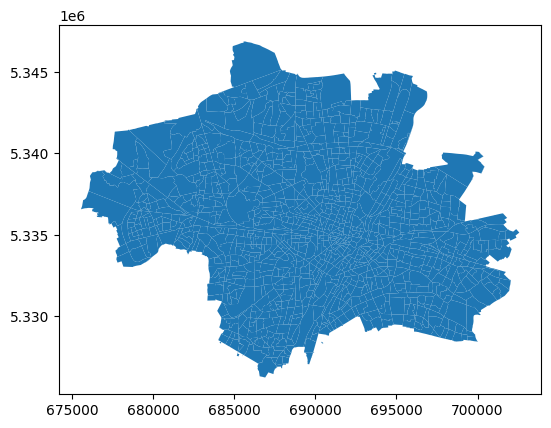

In [ ]:
visum_zones_clipped.plot()

In [ ]:
date = '2019-12-05'

daily_temperatur_cycle = k.loc[date]
daily_traffic_cycle = counts.get_hourly_scaling_factors(date = date).loc['PC']

15.4276875
17.91477887579524
T20°C,tØ,dØ


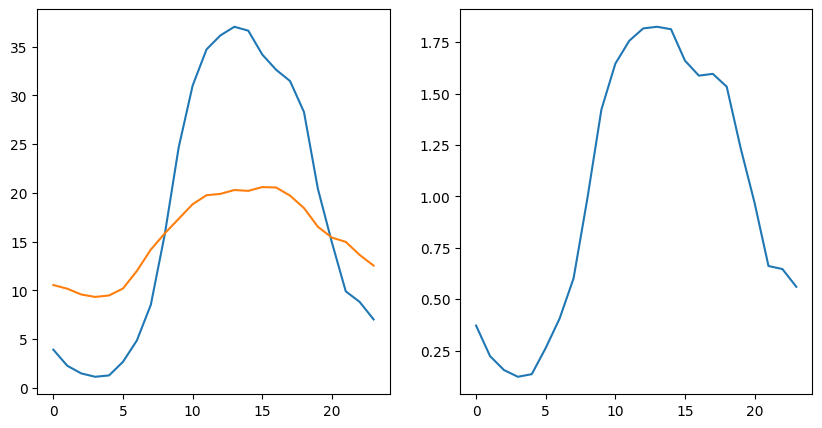

In [ ]:
date = '2019-05-18'

daily_temperatur_cycle = k.loc[date]
daily_traffic_cycle = counts.get_hourly_scaling_factors(date = date).loc['PC']

weights = (daily_traffic_cycle/daily_traffic_cycle.mean()).to_numpy()
temperatures = daily_temperatur_cycle.to_numpy()

average = np.mean(temperatures)
weighted_temperature = (temperatures * weights)

weighted_average_temperature = np.mean(weighted_temperature)

print(np.mean(temperatures))
print(weighted_average_temperature)
print(get_amb_cond_pattern(weighted_average_temperature))


fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(weighted_temperature)
ax[0].plot(temperatures)

ax[1].plot(weights)

In [ ]:
cs.reset_index()['AmbientCondPattern'].unique()

array(['T+5°C,tØ,dØ', 'T+10°C,tØ,dØ', 'T+15°C,tØ,dØ', 'T+20°C,tØ,dØ',
       'T+25°C,tØ,dØ', 'ØGermany', 'T-10°C,tØ,dØ', 'T-5°C,tØ,dØ',
       'T+0°C,tØ,dØ'], dtype=object)

In [ ]:
def test_sum(a, b): 
    return a+b



visum_zones['test'] = visum_zones[['qv_pkw', 'qv_lkw_k']].apply(lambda x: test_sum(x['qv_pkw'], x['qv_lkw_k']), axis = 1)
    

,qv_pkw,qv_lkw_k,geometry,test
0,821.760,816.460,"POLYGON ((691754.076 5335024.558, 691738.991 5...",1638.220
1,1271.342,1082.346,"POLYGON ((691738.353 5335092.229, 691738.991 5...",2353.688
2,263.395,1079.766,"POLYGON ((692276.321 5334907.600, 692274.227 5...",1343.161
3,532.558,537.905,"POLYGON ((691926.924 5334982.696, 692026.581 5...",1070.463
4,642.092,521.931,"POLYGON ((691832.321 5334837.440, 691834.223 5...",1164.023
...,...,...,...,...
1503,2176.368,331.232,"POLYGON ((680165.304 5329164.754, 680097.204 5...",2507.600
1504,1756.646,269.778,"POLYGON ((679008.128 5329774.304, 679007.598 5...",2026.424
1505,3134.188,598.513,"POLYGON ((674455.149 5326697.935, 674434.743 5...",3732.701
1506,724.102,90.547,"POLYGON ((679095.869 5322663.619, 679162.521 5...",814.649
